# Chapter 4: Bayesian Statistics in pymc3 (Working in progress proof of concept)

In [1]:
# These two lines are necessary only if gempy is not installed
import sys, os
sys.path.append("../..")

# Importing gempy
import gempy as gp


# Embedding matplotlib figures into the notebooks
%matplotlib notebook

# Aux imports
import numpy as np

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
# Importing the data from csv files and settign extent and resolution
geo_data = gp.create_data([696000-10000,747000 + 20600,6863000 - 20600,6950000 + 20600,-20000, 600],
                          [30,30,30],
                         path_f = os.pardir+"/input_data/a_Foliations.csv",
                         path_i = os.pardir+"/input_data/a_Points.csv")

../../gempy/data_management.py:66: UserWarning: path_f is deprecated use instead path_o
  warnings.warn('path_f is deprecated use instead path_o')


here
2
3
there


1
there


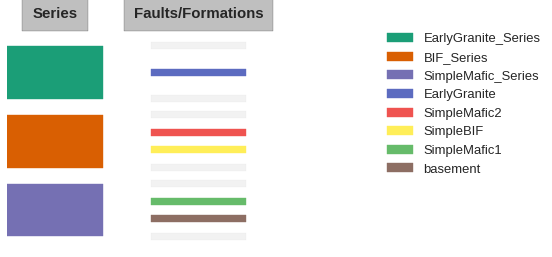

In [3]:
# Assigning series to formations as well as their order (timewise)
gp.set_series(geo_data, {"EarlyGranite_Series": 'EarlyGranite', 
                              "BIF_Series":('SimpleMafic2', 'SimpleBIF'),
                              "SimpleMafic_Series":'SimpleMafic1'}, 
                      order_series = ["EarlyGranite_Series",
                                      "BIF_Series",
                                      "SimpleMafic_Series"],
                      order_formations= ['EarlyGranite', 'SimpleMafic2', 'SimpleBIF', 'SimpleMafic1'],
              verbose=1)

In [4]:
geo_data.set_formation_values([2.61, 2.92, 3.1, 2.91, 2.61])

I am changing formations3


In [5]:
geo_data.formations

,value,formation_number
EarlyGranite,2.61,1
SimpleMafic2,2.92,2
SimpleBIF,3.10,3
SimpleMafic1,2.91,4
basement,2.61,5


In [6]:
geo_data.update_df()

1
there


Setting uncertainties adding the values to the Dataframe.

In [7]:
geo_data.interfaces['X_std'] = None
geo_data.interfaces['Y_std'] = 0
geo_data.interfaces['Z_std'] = 100

geo_data.orientations['X_std'] = None
geo_data.orientations['Y_std'] = 0
geo_data.orientations['Z_std'] = 100

geo_data.orientations['dip_std'] = 10
geo_data.orientations['azimuth_std'] = 10
geo_data.orientations.head()

,X,Y,Z,G_x,G_y,G_z,dip,azimuth,polarity,formation,...,formation_number,order_series,isFault,annotations,formation_value,X_std,Y_std,Z_std,dip_std,azimuth_std
0,732683.4690,6882332.75,481.711952,0.310842,-0.934464,0.173648,80.0,161.600709,1,EarlyGranite,...,1,1,False,"${\bf{x}}_{\beta \,{\bf{1}},0}$",2.61,None,0,100,10,10
1,730627.5315,6880472.50,477.402658,0.844266,-0.507012,0.173648,80.0,120.986348,1,EarlyGranite,...,1,1,False,"${\bf{x}}_{\beta \,{\bf{1}},1}$",2.61,None,0,100,10,10
2,728767.4065,6878759.25,470.031623,0.238570,-0.955474,0.173648,80.0,165.980598,1,EarlyGranite,...,1,1,False,"${\bf{x}}_{\beta \,{\bf{1}},2}$",2.61,None,0,100,10,10
3,728571.5940,6879934.25,472.536776,-0.862410,0.475494,0.173648,80.0,298.870347,1,EarlyGranite,...,1,1,False,"${\bf{x}}_{\beta \,{\bf{1}},3}$",2.61,None,0,100,10,10
4,729256.9065,6882724.50,471.722924,-0.982254,-0.070879,0.173648,80.0,265.872737,1,EarlyGranite,...,1,1,False,"${\bf{x}}_{\beta \,{\bf{1}},4}$",2.61,None,0,100,10,10


## Real gravity

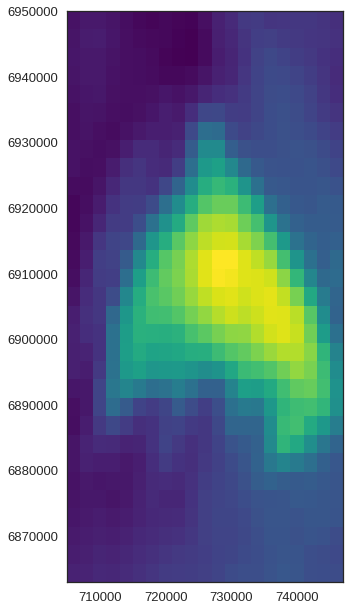

In [9]:
import matplotlib.pyplot as plt
import pandas as pn
grav_real = pn.read_csv('../input_data/Sst_grav_2000.xyz', header=None, names = ['X', 'Y', 'N', 'G'], delim_whitespace=True)
plt.imshow(grav_real['G'].values.reshape(31,21), extent=[7.050000e+05,747000,6863000,6950000], origin='lower', cmap='viridis')
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

In [10]:
# Calibration parameters
# F_min, F_max =  np.min(Forw), np.max(Forw)   #36.630742, 36.651496    #30.159309, 30.174104#
# F_range = F_max - F_min
# F_mid = 0.5*(F_max+F_min)

rs_min, rs_max = np.min(grav_real['G']), np.max(grav_real['G'])
rs_range = rs_max - rs_min
rs_mid = 0.5*(rs_max+rs_min)

#Rescaling

# rs_mid + (grid - m_mid) / m_range * rs_range
# Reescaled_forw = rs_mid + (Forw - F_mid) / F_range * rs_range

In [11]:
import theano
grav_real_mid = theano.shared(rs_mid, 'Grav_real_mid')
grav_real_range = theano.shared(rs_range, 'Grav_real_range')
grav_real_th = theano.shared(grav_real['G'].as_matrix())

In [12]:
grav_real_th.get_value().shape

(651,)

In [13]:
# input_data_T = interp_data.interpolator.tg.input_parameters_list()
# input_data_P = interp_data.get_input_data(u_grade=[3, 3])
# select = interp_data.interpolator.pandas_rest_layer_points['formation'] == 'Reservoir'

In [14]:
interp_data_grav = gp.InterpolatorData(geo_data, output='gravity',
                                       compile_theano=False, dtype='float64',
                                       theano_optimizer='fast_compile',
                                       u_grade=[1,1,1], verbose=[])

gp.set_geophysics_obj(interp_data_grav,  [7.050000e+05,747000,6863000,6925000,-20000, 200],
                                             [31,21])

gp.precomputations_gravity(interp_data_grav, 25, 
                           [2.92, 3.1, 2.92, 2.61, 2.61])

(array([[  4.38731560e-04,   4.01484841e-04,   3.59367023e-04, ...,
           1.48898222e-04,   8.87480008e-05,   2.72122954e-05],
        [  4.38731560e-04,   4.01484841e-04,   3.59367023e-04, ...,
           1.48898222e-04,   8.87480008e-05,   2.72122954e-05],
        [  4.38731560e-04,   4.01484841e-04,   3.59367023e-04, ...,
           1.48898222e-04,   8.87480008e-05,   2.72122954e-05],
        ..., 
        [  4.38731560e-04,   4.01484841e-04,   3.59367023e-04, ...,
           1.48898222e-04,   8.87480008e-05,   2.72122954e-05],
        [  4.38731560e-04,   4.01484841e-04,   3.59367023e-04, ...,
           1.48898222e-04,   8.87480008e-05,   2.72122954e-05],
        [  4.38731560e-04,   4.01484841e-04,   3.59367023e-04, ...,
           1.48898222e-04,   8.87480008e-05,   2.72122954e-05]]),
 array([False, False, False, ..., False, False, False], dtype=bool))

In [15]:
interp_data_grav.geo_data_res.x_to_interp_given

array([[ 0.31239727,  0.26427238,  0.43420065],
       [ 0.31239727,  0.26427238,  0.43875562],
       [ 0.31239727,  0.26427238,  0.44331059],
       ..., 
       [ 0.83564421,  1.08633658,  0.55718491],
       [ 0.83564421,  1.08633658,  0.56173988],
       [ 0.83564421,  1.08633658,  0.56629485]])

In [16]:
#a,b = gp.precomputations_gravity(interp_data_grav, 24, [2.92, 3.1, 2.92, 2.61, 2.61])

In [17]:
#sol[0][1]

In [18]:
#theano.config.compute_test_value = 'off'

sol = gp.compute_model(interp_data_grav, output='gravity')

Compiling theano function...
Compilation Done!
Level of Optimization:  fast_compile
Device:  cpu
Precision:  float64
Number of faults:  0
density block __str__ = [ 2.61  2.61  2.61 ...,  2.61  2.61  2.61]


[[ 2.61        2.61        2.61       ...,  2.61        2.61        2.61      ]
 [ 2.61        2.61        2.61       ...,  2.61        2.61        2.61      ]
 [ 2.61        2.61        2.61       ...,  2.61        2.61        2.61      ]
 ..., 
 [ 2.61        2.61        2.61       ...,  3.0994998   3.09950877
   3.09952532]
 [ 2.61        2.61        2.61       ...,  3.09979512  3.09979937
   3.09980669]
 [ 2.61        2.61        2.61       ...,  3.09991573  3.09991772
   3.09992095]] <class 'numpy.ndarray'>


<IPython.core.display.Javascript object>


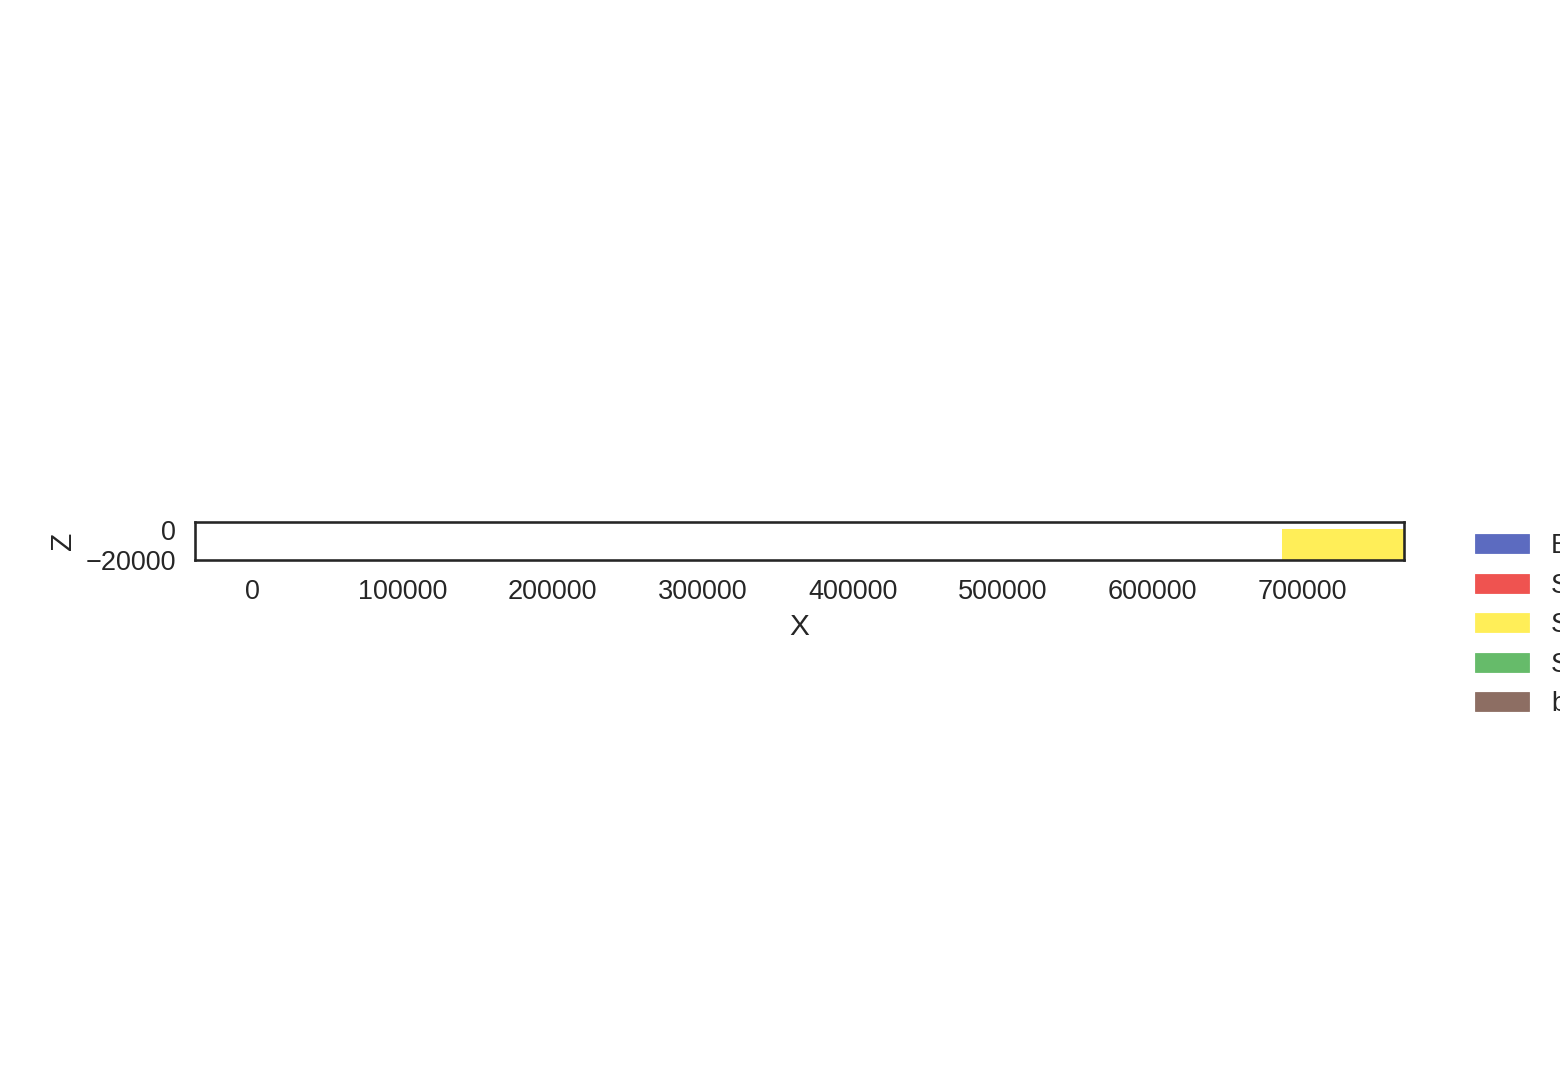

In [17]:
%matplotlib notebook
gp.plot.plot_section(geo_data, sol[0][0], 20)

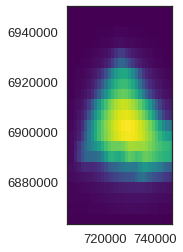

In [34]:
plt.imshow(sol[2].reshape(21,31), cmap='viridis', origin='lower', extent=[7.050000e+05,747000,6863000,6950000] )


Now the generation of the geomodel will be an operation embedded in a larger tree.

In [26]:
import theano
import theano.tensor as T
geomodel = theano.OpFromGraph(interp_data_grav.interpolator.tg.input_parameters_list(),
                              [interp_data_grav.interpolator.tg.covariance_matrix()],
                              on_unused_input='ignore',
                            )

In [27]:
input_sh = []
for i in interp_data_grav.get_input_data():
    input_sh.append(theano.shared(i))

In [28]:
input_sh

[<TensorType(float64, matrix)>,
 <TensorType(float64, vector)>,
 <TensorType(float64, vector)>,
 <TensorType(float64, vector)>,
 <TensorType(float64, matrix)>,
 <TensorType(float64, matrix)>]

In [29]:
e = geomodel(*input_sh)
der = theano.grad(e[0,0], input_sh[-3])

DisconnectedInputError:  
Backtrace when that variable is created:

  File "/home/miguel/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/miguel/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/home/miguel/anaconda3/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/miguel/anaconda3/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/miguel/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2728, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/miguel/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2850, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/miguel/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-27-b19de8e243c7>", line 3, in <module>
    input_sh.append(theano.shared(i))


In [22]:
a = theano.function(interp_data_grav.interpolator.tg.input_parameters_list(), [e], on_unused_input='ignore')

In [25]:
np.unique(a(*interp_data_grav.get_input_data())[0])

array([  2.61      ,   2.61      ,   2.61      , ...,  24.33333969,
        24.33493233,  24.33651733])

In [24]:
plt.imshow(a(*interp_data_grav.get_input_data())[0].reshape(21,31), cmap='viridis', origin='lower', extent=[7.050000e+05,747000,6863000,6950000] )



ValueError: total size of new array must be unchanged

Because now the GeMpy model is a theano operation and not a theano function, to call it we need to use theano variables (with theano functions we call them with python variables). This is very easy to modify, we just need to use theano shared to convert our python input data into theano variables.

The pymc3 objects are already theano variables (pm.Normal and so on). Now the trick is that using the theano function T.set_subtensor, we can change one deterministic value of the input arrays(the ones printed in the cell above) by a stochastic pymc3 object. Then with the new arrays we just have to call the theano operation and pymc will do the rest

In [ ]:
# This is the creation of the model
import pymc3 as pm

theano.config.compute_test_value = 'warn'
dtype='float64'
#theano.config.warn_float64 = 'warn'
model = pm.Model()
with model:
    # We create the Stochastic parameters. In this case only the Z position
    # of the interfaces
    Z_rest = pm.Normal('Z_unc_rest',
       interp_data_grav.interpolator.pandas_rest_layer_points['Z'].as_matrix().astype('float32'),
       interp_data_grav.interpolator.pandas_rest_layer_points['Z_std'].as_matrix().astype('float32'),
                  dtype=dtype, shape = (66))
    
    Z_ref = pm.Normal('Z_unc_ref', interp_data_grav.interpolator.pandas_ref_layer_points_rep['Z'].as_matrix().astype('float32'),
              interp_data_grav.interpolator.pandas_ref_layer_points_rep['Z_std'].as_matrix().astype('float32'),
              dtype=dtype, shape = (66))
    
    dip_unc = pm.Normal('dip_unc', interp_data_grav.geo_data_res.orientations['dip'].as_matrix(),
                        interp_data_grav.geo_data_res.orientations['dip_std'].as_matrix(),
                       dtype=dtype, shape = (41))
    
    azimuth_unc = pm.Normal('azimuth_unc', interp_data_grav.geo_data_res.orientations['azimuth'].as_matrix(), 
                            interp_data_grav.geo_data_res.orientations['azimuth_std'].as_matrix(),
                       dtype=dtype, shape = (41))
    
#     Z_unc = pm.Normal('Z_unc', interp_data_grav.geo_data_res.interfaces['Z'].astype('float32'),
#                       interp_data_grav.geo_data_res.interfaces['Z_std'].astype('float32'), dtype='float32', shape= (70))
    
#     interp_data_grav.geo_data_res.interfaces['Z'] = Z_unc
    
    # We convert a python variable to theano.shared
    input_sh = []
    for i in interp_data_grav.get_input_data():
        input_sh.append(theano.shared(i))
    
    # We add the stochastic value to the correspondant array. rest array is
    # a n_points*3 (XYZ) array. We only want to change Z in this case.
    input_sh[4] = T.set_subtensor(
    input_sh[4][:, 2], Z_ref)

    input_sh[5] = T.set_subtensor(
    input_sh[5][:, 2], Z_rest)
    
    # With the stochastic parameters we create the geomodel result:
    Forw = pm.Deterministic('GemPy', geomodel(input_sh[0], input_sh[1], input_sh[2],
                                                   input_sh[3], input_sh[4], input_sh[5]))
    
    # Calibration parameters
    F_min, F_max =  T.min(Forw), T.max(Forw)   #36.630742, 36.651496    #30.159309, 30.174104#
    F_range = F_max - F_min
    F_mid = 0.5*(F_max+F_min)
    
    Reescaled_forw = grav_real_mid + (Forw - F_mid) / F_range * grav_real_range
    
    e_sq = T.sqrt(T.sum(T.square(Reescaled_forw - (grav_real_th))))

    Y_obs = pm.HalfCauchy('Y_obs', beta=e_sq, observed=1000)

In [ ]:
#import theano.tensor as T
#import pymc3 as pm
#pm.HalfCauchy?

In [ ]:
theano.config.compute_test_value = 'off'
# This is the sampling
# BEFORE RUN THIS FOR LONG CHECK IN THE MODULE THEANOGRAF THAT THE FLAG 
# THEANO OPTIMIZER IS IN 'fast_run'!!
with model:
   # backend = pm.backends.ndarray.NDArray('geomodels')
    #step = pm.NUTS()
    trace = pm.sample(30, tune=10, n_init=10, live_plot=True, refresh_every=1, cores=1 )

In [ ]:
trace.get_values('GemPy')[5].shape, 31*21

In [ ]:
trace.varnames

In [ ]:
%matplotlib inline
pm.plot_posterior(trace, varnames=['Z_unc_rest'])

In [ ]:
trace.get_values('GemPy')[5] -  trace.get_values('GemPy')[15]

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(trace.get_values('GemPy')[-10].reshape(50,50), cmap='viridis', origin='lower', extent=[7.050000e+05,747000,6863000,6950000] )
plt.colorbar()

In [ ]:
import matplotlib.pyplot as plt
for i in range(100):
    gp.plot_section(geo_data, trace.get_values('GemPy')[i][0, :], 18,
                       direction='y', plot_data=False)
    plt.show()

In [ ]:
from theano.printing import pydotprint

pydotprint(model.logpt)